 # Calculating OPRs

In [2]:
# Set up environment
import tbapy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import time
import os

tba = tbapy.TBA(os.environ['TBA_API_KEY'])


 ## Data Manipulation

 First we need to organize our data into a more useful format. This OPR model
 doesn't model interaction effects in opponent alliances, so we will split the
 data along alliance (i.e. each match has two rows--one for the blue and one
 for the red alliance). These rows aren't associated with one another in any
 way--we're pretending that the two alliances don't interact at all.

In [3]:
# Build data structure
YEAR = 2018
DROPS = ['Year','Event','Week','comp_level','set','match','winner']
COLS_REN = {
    'Key': 'key',
    'blue score':'score',  'blue':'teams',
    'red score':'score',   'red':'teams'
}

data = pd.read_csv(f"../data/{YEAR}_MatchData_ol.csv")
data = models.process_data(data)
data = models.sort_data(data)
data = data.drop(DROPS, axis=1)

# Break up into alliances
blue = data.loc[:, ['Key','blue score','blue']]
blue['alliance'] = ['blue']*len(blue)
blue.rename(columns=COLS_REN, inplace=True)
blue.index = blue.index * 2

red = data.loc[:, ['Key','red score','red']]
red['alliance'] = ['red']*len(red)
red.rename(columns=COLS_REN, inplace=True)
red.index = red.index * 2 + 1

# Shuffle data back together
data = pd.concat([blue,red], axis=0).sort_index()
data = data[['key','alliance','teams','score']]

# Get a list of teams
teams = list(set([t for a in data.teams for t in a]))

data.head(10)


FileNotFoundError: [Errno 2] File b'../data/2018_MatchData_ol.csv' does not exist: b'../data/2018_MatchData_ol.csv'

 ## Math etc.

 Now we can build what we will call the sparse matrix. This is just one of our
 component matrices, but I term it the sparse matrix only because the data we
 have is incredibly sparse--most teams never play with one another, and each
 team doesn't play in very many matches. This matrix has columns which are
 teams and rows, which are alliance-matches. Each row has a 1 for each team
 that competed in that alliance-match.

 ### Optimization

 We have optimized this process a lot! Populating the sparse matrix was slowed
 down significantly by the fact that we were doing it on a pandas dataframe. By
 working with a dictionary instead, we can use the `update` function to speed
 up our indexing by orders of magnitude.

 First we'll build an empty matrix. This is a dictionary holding a lot of
 dictionaries, the first axis being the match-alliance id and the second being
 team. This data structure is much faster to index into than the dataframe we
 were using before, so we can build our sparse matrix almost instantly.

In [ ]:
# Build sparse matrix
row = {t:0 for t in teams}
sparse = {f"{r.key}_{r.alliance[0]}":dict(row) for i,r in data.iterrows()}


 Here we populate the matrix (which is currently all zeros) with 1's everywhere
 that a team participated in the alliance-match in question. We'll iterate over
 the original dataframe again, but this time we'll use the faster indexing
 function of the dictionary instead of slow pandas indexing to insert values
 back into the sparse matrix.

In [ ]:
# Populate matrix
def build_sparse(row):
    sparse[f"{row.key}_{row.alliance[0]}"].update(dict(zip(row.teams, [1,1,1])))

data.apply(build_sparse, axis=1)


 In order to perform numpy operations, we need to convert this layered
 dictionary back into a numpy array.

In [4]:
# Deconstruct sparse dictionary into matrix
sparse_m = np.array([list(d.values()) for d in sparse.values()])
sparse_m


NameError: name 'sparse' is not defined

 Having built our data structures, we simply use numpy's least-squares
 algorithm to solve the system with the sparse matrix and score column.

In [6]:
# Solve the matrix
oprs,resid,_,_ = np.linalg.lstsq(sparse_m, data.score, rcond=None)


In [7]:
# Display OPRs
opr_dict = { t:o for (t,o) in zip(teams, oprs) }

opr_table = pd.DataFrame({'team':teams, 'opr':oprs})
opr_table.sort_values('opr', ascending=False, inplace=True)
opr_table.head()


,team,opr
379,987,39.253063
810,2056,39.035562
28,67,38.794041
166,341,36.102811
129,254,34.836332


 ## Analytics

 How useful are world OPRs really? We can look at a distribution of all teams'
 OPRs to get a sense of how quality is distributed among the teams.

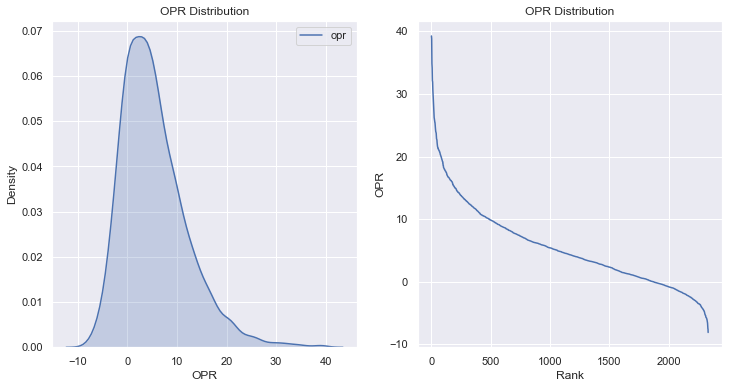

In [8]:
# Visualize OPRs
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
sns.kdeplot(opr_table.opr, shade=True, ax=ax1)
ax1.set_title("OPR Distribution")
ax1.set_xlabel("OPR")
ax1.set_ylabel("Density")

ax2.plot(list(opr_table.opr))
ax2.set_title("OPR Distribution")
ax2.set_xlabel("Rank")
ax2.set_ylabel("OPR")

fig.show()


 How useful are these predictions? It's hard to say. Let's put some numbers on
 the board. We already have the residuals, so we can find the MSE very easily.

Mean Squared Error: 126.23832387707127
Square root: 11.23558293445744


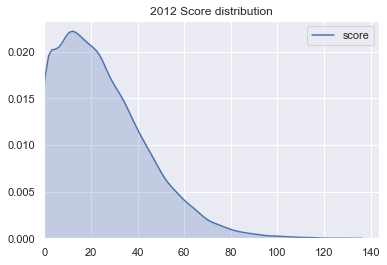

In [9]:
print("Mean Squared Error:", resid[0] / len(data))
print("Square root:", np.sqrt(resid[0] / len(data)))
sns.kdeplot(data.score, shade=True)
plt.title(f"{YEAR} Score distribution")
plt.xlim(left=0)
plt.show()


 This makes it look like our predictions aren't very good. Most scores are
 below 40, and we have a mean squared error of about 11 for each
 alliance-match. However, to understand our margin of error better, we'll need
 to construct our own residuals so we can examine them more closely.

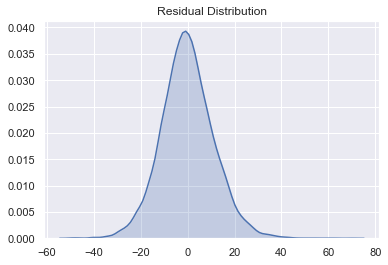

In [10]:
# Test OPR accuracy
def predict(alliance):
    return sum([opr_dict[t] for t in alliance])

def diff(row):
    return row.score - predict(row.teams)
    
residuals = data.apply(diff, axis=1)
sns.kdeplot(residuals, shade=True)
plt.title("Residual Distribution")
plt.show()


 It looks like our residuals are approximately normally distributed, which is
 good! This means our model isn't biased too much in either direction. We might
 want to look at our median error as a more useful predictor of how far off our
 results are.

In [11]:
print("Median (absolute) error:", np.sqrt(np.square(residuals).median()))


Median (absolute) error: 7.008087389832455


 This makes it look like our prediction model is probably a bit more accurate,
 although it's influenced by outliers--essentially, it can't predict when teams
 have standout performances.

 We might ask, however, whether we can at least predict match outcomes--maybe
 we can't tell what the margin of victory will be, but at least maybe we can
 find the victor and a rough sense of their likelihood to win.

 ## Conclusion
 This isn't a very suprising result. We expect OPRs to be mediocre at best even
 on the event scale, where data is much less sparse and more useful. However,
 we can see that world OPRs can be calculated very easily, and with some degree
 of accuracy. We might expect them to be useful as an addition to another
 model, but on their own, they make too many assumptions, chiefly the
 assumption of independence, to be an accurate predictor.